<a href="https://colab.research.google.com/github/Hanchaeeun/HanChaeEun/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install shap

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import shap
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
plt.rc('font', family='NanumBarunGothic') #set font
plt.rc('axes', unicode_minus=False)

# Data Road

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/tmp_data/Data.csv')
print(df.shape)
df

(61343, 16)


,일시,기온,강수량,풍속,풍향,습도,해면기압,일조,일사,전운량,시정,시간,남중고도,PM10,태양광,월
0,2013-01-01,-2.0,NaN,4.1,160.0,93.0,1021.4,NaN,NaN,3.0,2000.0,0,75.630111,135.0,0.0,1
1,2013-01-01,-2.2,NaN,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,NaN,1,77.254281,44.0,0.0,1
2,2013-01-01,-2.4,NaN,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,NaN,2,68.558811,34.0,0.0,1
3,2013-01-01,-2.7,NaN,3.6,160.0,95.0,1020.8,NaN,NaN,7.0,1800.0,3,56.934467,41.0,0.0,1
4,2013-01-01,-2.9,NaN,4.0,160.0,94.0,1020.0,NaN,NaN,7.0,1800.0,4,44.702936,41.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61338,2019-12-31,-2.0,NaN,8.2,360.0,61.0,1034.0,NaN,NaN,5.0,2000.0,19,17.385772,17.0,0.0,12
61339,2019-12-31,-2.8,NaN,4.6,20.0,65.0,1033.9,NaN,NaN,7.0,2000.0,20,29.383611,13.0,0.0,12
61340,2019-12-31,-2.8,NaN,3.3,20.0,65.0,1033.9,NaN,NaN,9.0,2000.0,21,41.632719,17.0,0.0,12
61341,2019-12-31,-2.6,NaN,4.7,20.0,63.0,1033.5,NaN,NaN,9.0,2000.0,22,53.907639,13.0,0.0,12


In [ ]:
def drop_idx(df):
  idx = df[df['태양광'] == 0].index
  df.drop(idx, inplace=True)
  df.dropna(subset=['태양광'], inplace=True)
  df.reset_index(inplace=True, drop=True)
  return df

In [ ]:
drop_idx(df)

,일시,기온,강수량,풍속,풍향,습도,해면기압,일조,일사,전운량,시정,시간,남중고도,PM10,태양광,월
0,2013-01-01,2.6,0.0,6.0,290.0,91.0,1019.6,0.0,0.03,10.0,1300.0,9,12.470572,43.0,20.16,1
1,2013-01-01,4.2,NaN,5.8,250.0,82.0,1019.9,0.7,0.57,7.0,1300.0,10,21.110853,56.0,106.80,1
2,2013-01-01,3.8,NaN,7.1,320.0,80.0,1020.5,0.7,1.00,9.0,1300.0,11,27.690225,75.0,469.56,1
3,2013-01-01,4.9,0.1,2.8,290.0,73.0,1020.1,0.7,1.05,7.0,1300.0,12,31.491442,84.0,504.24,1
4,2013-01-01,5.2,NaN,6.7,320.0,66.0,1019.7,0.8,1.14,6.0,1100.0,13,31.957150,78.0,745.20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31292,2019-12-31,-1.5,NaN,9.1,360.0,59.0,1033.5,0.5,1.04,7.0,2000.0,14,28.822939,24.0,1148.52,12
31293,2019-12-31,-1.5,NaN,9.9,360.0,55.0,1033.6,0.9,1.43,6.0,2000.0,15,22.893481,21.0,830.88,12
31294,2019-12-31,-1.7,NaN,8.9,360.0,60.0,1034.0,0.8,0.86,7.0,2000.0,16,14.724322,20.0,550.92,12
31295,2019-12-31,-1.9,NaN,8.8,360.0,61.0,1034.3,0.8,0.39,6.0,2000.0,17,4.975967,22.0,74.28,12


In [ ]:
def deviation(df, col):  
  for m in df['월'].unique():
    for h in range(7,20):
      h_df = df[(df['월'] == m) & (df['시간'] == h)]
      idx = h_df.index
      mean = h_df[col].mean()
      
      for i in idx:
        df.loc[i,f'{col}편차'] = df.loc[i,col] - mean
  return df

In [ ]:
deviation(df, '태양광')

,일시,기온,강수량,풍속,풍향,습도,해면기압,일조,일사,전운량,시정,시간,남중고도,PM10,태양광,월,태양광편차
0,2013-01-01,2.6,0.0,6.0,290.0,91.0,1019.6,0.0,0.03,10.0,1300.0,9,12.470572,43.0,20.16,1,-24.486256
1,2013-01-01,4.2,NaN,5.8,250.0,82.0,1019.9,0.7,0.57,7.0,1300.0,10,21.110853,56.0,106.80,1,-138.698791
2,2013-01-01,3.8,NaN,7.1,320.0,80.0,1020.5,0.7,1.00,9.0,1300.0,11,27.690225,75.0,469.56,1,-54.371111
3,2013-01-01,4.9,0.1,2.8,290.0,73.0,1020.1,0.7,1.05,7.0,1300.0,12,31.491442,84.0,504.24,1,-241.906728
4,2013-01-01,5.2,NaN,6.7,320.0,66.0,1019.7,0.8,1.14,6.0,1100.0,13,31.957150,78.0,745.20,1,-79.743041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31292,2019-12-31,-1.5,NaN,9.1,360.0,59.0,1033.5,0.5,1.04,7.0,2000.0,14,28.822939,24.0,1148.52,12,485.635535
31293,2019-12-31,-1.5,NaN,9.9,360.0,55.0,1033.6,0.9,1.43,6.0,2000.0,15,22.893481,21.0,830.88,12,424.761667
31294,2019-12-31,-1.7,NaN,8.9,360.0,60.0,1034.0,0.8,0.86,7.0,2000.0,16,14.724322,20.0,550.92,12,304.009217
31295,2019-12-31,-1.9,NaN,8.8,360.0,61.0,1034.3,0.8,0.39,6.0,2000.0,17,4.975967,22.0,74.28,12,21.539163


In [ ]:
cols = [x for x in df.columns if x not in ['강수량', '시간', '월', '태양광']] #null이 많은 강수량 변수 제외
cols

['일시',
 '기온',
 '풍속',
 '풍향',
 '습도',
 '해면기압',
 '일조',
 '일사',
 '전운량',
 '시정',
 '남중고도',
 'PM10',
 '태양광편차']

In [ ]:
print(len(df[cols]))
test_df = df[cols].dropna(how='any')
test_df.reset_index(inplace=True, drop=True)
test_df

31297


,일시,기온,풍속,풍향,습도,해면기압,일조,일사,전운량,시정,남중고도,PM10,태양광편차
0,2013-01-01,2.6,6.0,290.0,91.0,1019.6,0.0,0.03,10.0,1300.0,12.470572,43.0,-24.486256
1,2013-01-01,4.2,5.8,250.0,82.0,1019.9,0.7,0.57,7.0,1300.0,21.110853,56.0,-138.698791
2,2013-01-01,3.8,7.1,320.0,80.0,1020.5,0.7,1.00,9.0,1300.0,27.690225,75.0,-54.371111
3,2013-01-01,4.9,2.8,290.0,73.0,1020.1,0.7,1.05,7.0,1300.0,31.491442,84.0,-241.906728
4,2013-01-01,5.2,6.7,320.0,66.0,1019.7,0.8,1.14,6.0,1100.0,31.957150,78.0,-79.743041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25873,2019-12-31,-1.5,9.1,360.0,59.0,1033.5,0.5,1.04,7.0,2000.0,28.822939,24.0,485.635535
25874,2019-12-31,-1.5,9.9,360.0,55.0,1033.6,0.9,1.43,6.0,2000.0,22.893481,21.0,424.761667
25875,2019-12-31,-1.7,8.9,360.0,60.0,1034.0,0.8,0.86,7.0,2000.0,14.724322,20.0,304.009217
25876,2019-12-31,-1.9,8.8,360.0,61.0,1034.3,0.8,0.39,6.0,2000.0,4.975967,22.0,21.539163


# ARIMA

In [ ]:
#태양광만 뽑아서 분포보기
timeSeries = test_df[['일시','태양광편차']]
timeSeries.index = timeSeries.일시
ts = timeSeries.drop(columns = '일시')
ts

,태양광편차
일시,
2013-01-01,-24.486256
2013-01-01,-138.698791
2013-01-01,-54.371111
2013-01-01,-241.906728
2013-01-01,-79.743041
...,...
2019-12-31,485.635535
2019-12-31,424.761667
2019-12-31,304.009217


<Figure size 432x288 with 0 Axes>

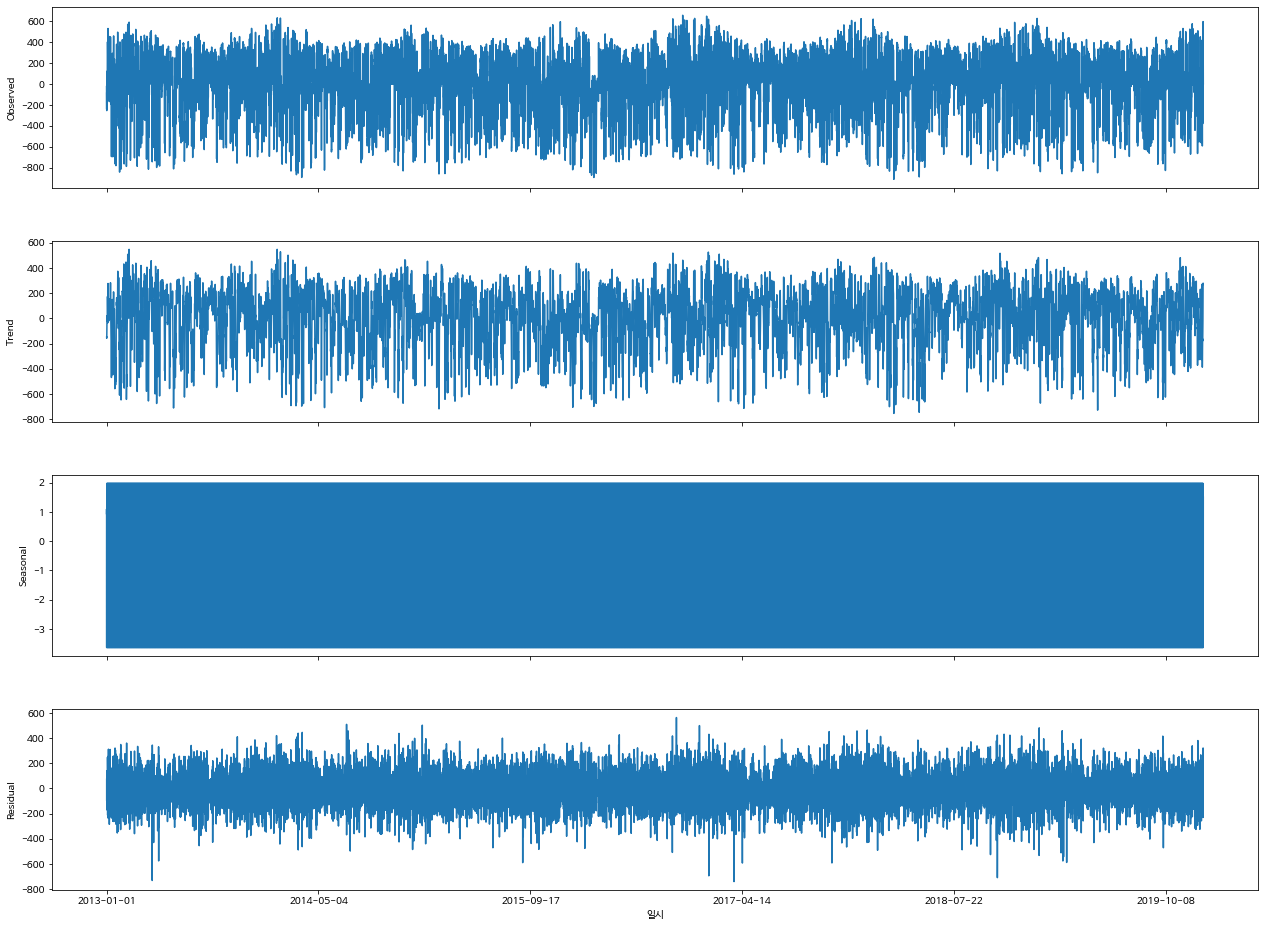

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['태양광편차'], model='additive', freq=7)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 15)

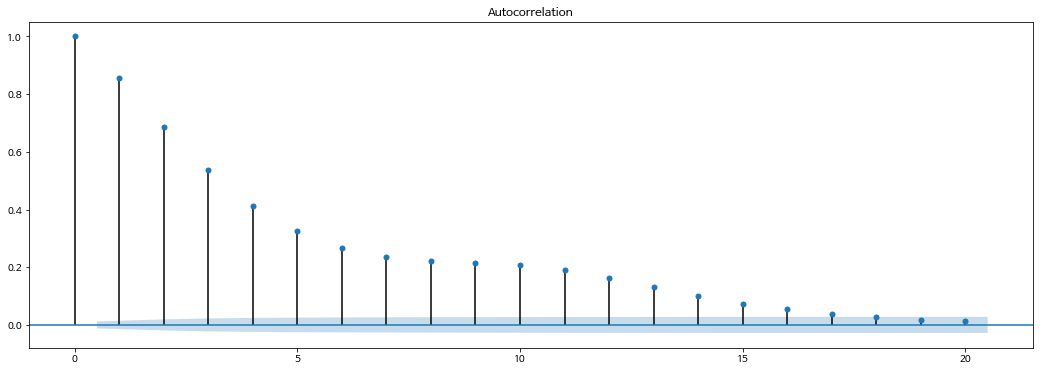

In [ ]:
fig, ax1 = plt.subplots(figsize=(18,6),ncols=1, nrows=1)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1) #0에 느리게 수렴하는 비정상 시계열 형태

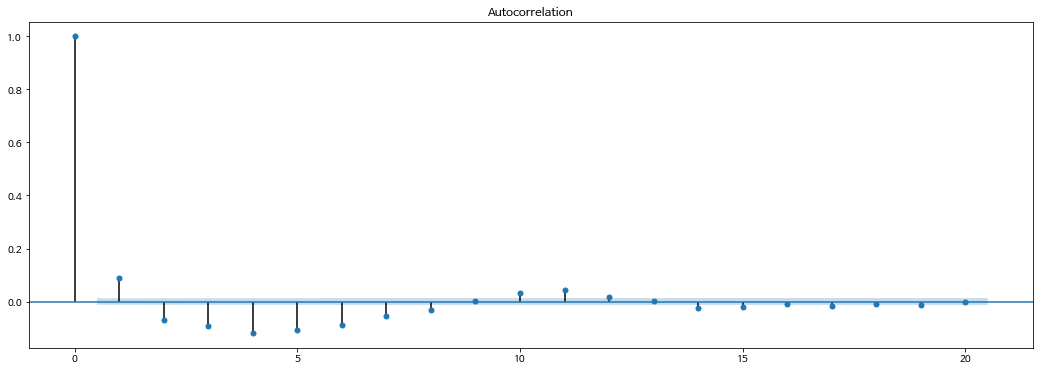

In [ ]:
ts_diff = ts - ts.shift() # 1차 차분
fig, ax1 = plt.subplots(figsize=(18,6),ncols=1, nrows=1)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1) #정상성을 만족하는 데이터로 변환 

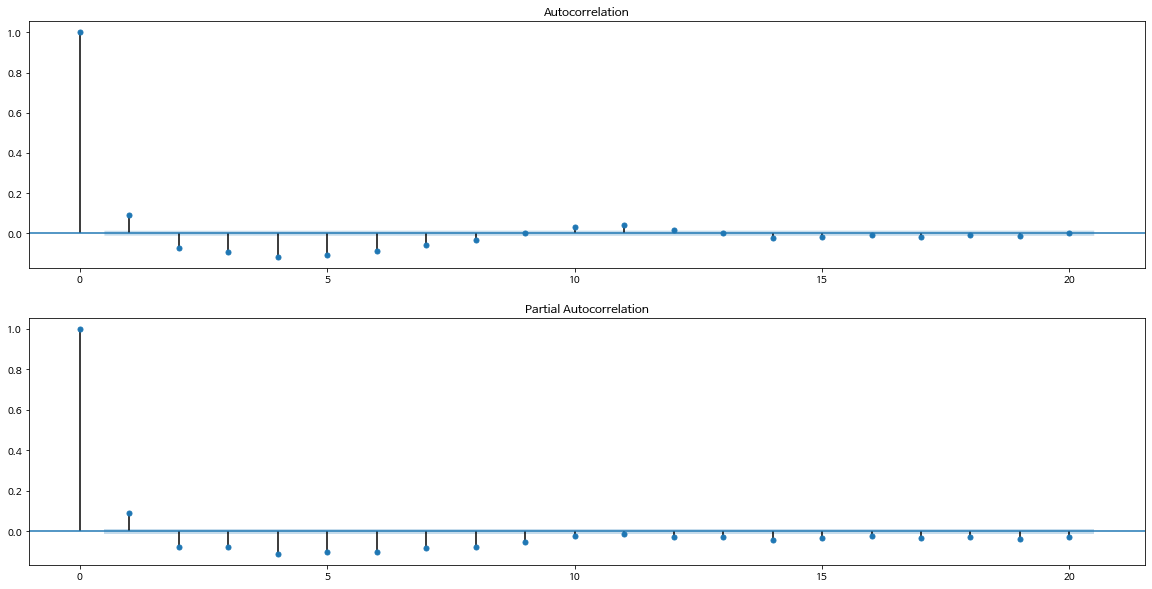

In [ ]:
#ARIMA 모형의 P와 q결정
fig, (ax1,ax2) = plt.subplots(figsize=(20,10), ncols=1, nrows=2)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1) #0.0 절단점에 2번째 lag부터 들어감 (q=1)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags=20, ax=ax2) #0.0 절단점에 2번째 lag부터 들어감 (p=1)

In [ ]:
#model 학습
model = ARIMA(ts, order=(1,1,1)) #ARIMA(p,d,q) (1,1,1)
model_fit = model.fit(disp=0)

#test
start_index = '2019-01-01'
end_index = '2019-12-31'
forecast = model_fit.predict(start=start_index, end=end_index, typ='levels')

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


In [ ]:
forecast

일시
2019-01-01      5.547776
2019-01-01    -31.200559
2019-01-01   -163.863534
2019-01-01   -217.706828
2019-01-01   -491.892596
                 ...    
2019-12-30    -18.248281
2019-12-30   -155.789646
2019-12-30   -129.528353
2019-12-30    -36.066240
2019-12-31     -2.558049
Length: 4173, dtype: float64

In [ ]:
ts_test = ts[ts.index >= '2019-01-01']
test = ts_test[:-9]
test

,태양광편차
일시,
2019-01-01,-37.326256
2019-01-01,-192.338791
2019-01-01,-255.251111
2019-01-01,-575.626728
2019-01-01,-579.543041
...,...
2019-12-30,-182.918333
2019-12-30,-152.230783
2019-12-30,-43.020837


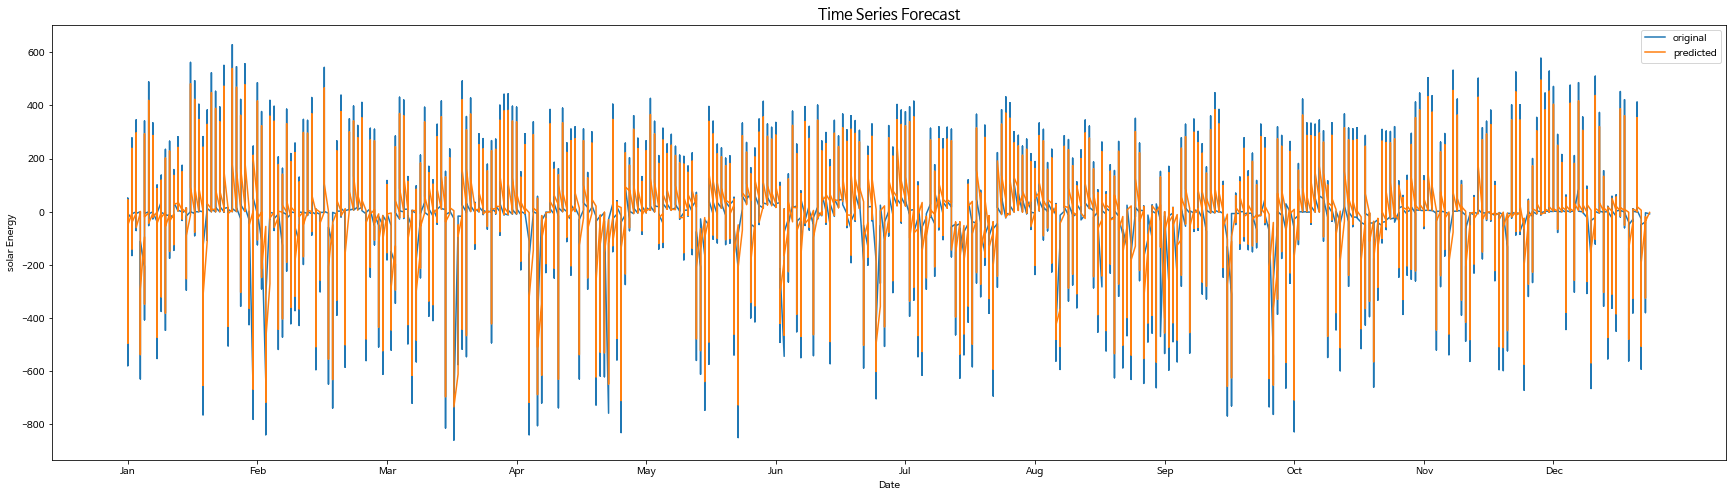

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(test.index, test.태양광편차, label="original" )
plt.plot(forecast, label="predicted")
plt.title("Time Series Forecast", fontsize=15)
plt.xlabel("Date")
plt.xticks(ticks=range(0,365,31), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel("solar Energy")
plt.legend(fontsize=10)
plt.show()

In [ ]:
y_true = np.array(test)
y_pred = np.array(forecast)
print(f'RMSE: {sqrt(mean_squared_error(y_true,y_pred))}')
print(f'r2score: {r2_score(y_true,y_pred)}')

RMSE: 136.01072846223624
r2score: 0.7235746002471211


# Result plot

In [55]:
r2_dic = {}
r2_dic['ARIMA'] = 0.7235746002471211
r2_dic['MLP'] = 0.6624234555490053
r2_dic['RF'] = 0.6757684352616435
r2_dic['LightGBM'] = 0.6419219127021
r2_dic['LSTM'] = 0.6622155917468051
r2_dic['GRU'] = 0.6767302017235891
r2_dic

{'ARIMA': 0.7235746002471211,
 'GRU': 0.6767302017235891,
 'LSTM': 0.6622155917468051,
 'LightGBM': 0.6419219127021,
 'MLP': 0.6624234555490053,
 'RF': 0.6757684352616435}

In [56]:
RMSE_dic = {}
RMSE_dic['ARIMA'] = 136.01072846223624
RMSE_dic['MLP'] = 134.92334796300196
RMSE_dic['RF'] = 126.17426658314152
RMSE_dic['LightGBM'] = 154.87761235403968
RMSE_dic['LSTM'] = 137.91875679461893
RMSE_dic['GRU'] = 136.86814137218124
RMSE_dic

{'ARIMA': 136.01072846223624,
 'GRU': 136.86814137218124,
 'LSTM': 137.91875679461893,
 'LightGBM': 154.87761235403968,
 'MLP': 134.92334796300196,
 'RF': 126.17426658314152}

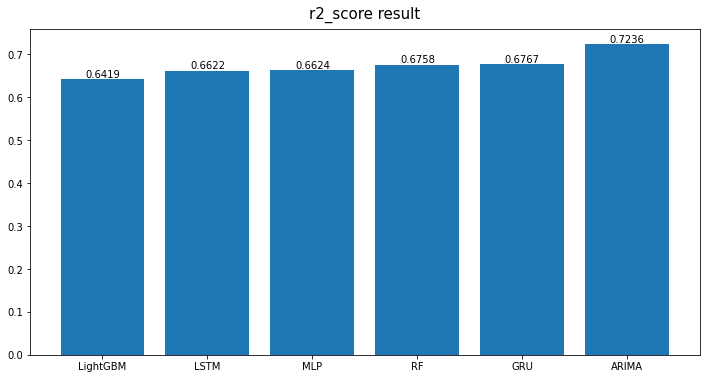

In [83]:
result_list = r2_dic.items()
result_list = sorted(result_list, key =lambda x : x[1])
x,y = zip(*result_list) #*을 이용해서 x,y 열끼리 묶어주기

fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('r2_score result', fontsize=15, pad=10)
bar = ax.bar(x, y)
for b in bar:
  X = b.get_x() + b.get_width()/2.0
  height = b.get_height()
  ax.text(X, height, '%.4f' %height, ha='center', va='bottom')

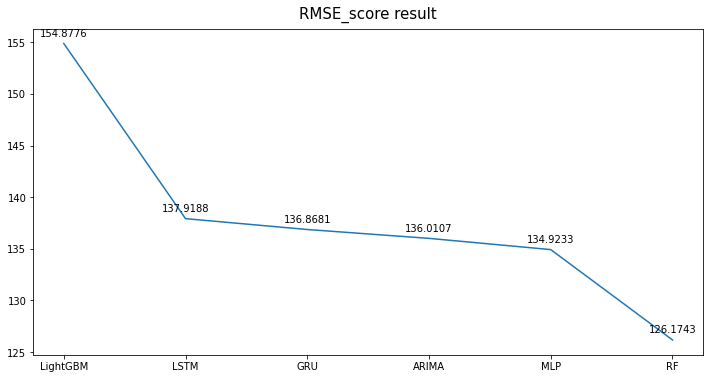

In [90]:
result_list = RMSE_dic.items()
result_list = sorted(result_list, key =lambda x : x[1], reverse = True)
x,y = zip(*result_list) #*을 이용해서 x,y 열끼리 묶어주기

fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('RMSE_score result', fontsize=15, pad=10)
plot = ax.plot(x, y)
for i in range(len(x)):
  height = y[i]
  ax.text(x[i], height + 0.5, '%.4f' %height, ha='center', va='bottom')